In [59]:
import tensorflow as tf
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import warnings
from PIL import Image
from skimage import transform
warnings.filterwarnings('ignore')

In [1]:
!nvidia-smi

Sun Dec 12 18:43:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2021-12-12 18:44:03--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  99.9MB/s    in 1.4s    

2021-12-12 18:44:05 (99.9 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2021-12-12 18:44:05--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================

In [3]:
!mkdir beans

In [4]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [12]:
!ls  beans/

test  train  validation


In [10]:
!find beans -type f | wc -l

1296


In [13]:
!find beans/test -type f | wc -l

128


In [15]:
!find beans/validation -type f | wc -l

133


In [16]:
!find beans/train -type f | wc -l

1035


In [19]:
!ls beans/train/

angular_leaf_spot  bean_rust  healthy


In [20]:
!ls beans/train/angular_leaf_spot  | head -4

angular_leaf_spot_train.0.jpg
angular_leaf_spot_train.100.jpg
angular_leaf_spot_train.101.jpg
angular_leaf_spot_train.102.jpg


In [23]:
!ls beans/train/bean_rust    | head -4

bean_rust_train.0.jpg
bean_rust_train.100.jpg
bean_rust_train.101.jpg
bean_rust_train.102.jpg


In [24]:
!ls beans/train/healthy    | head -4

healthy_train.0.jpg
healthy_train.100.jpg
healthy_train.101.jpg
healthy_train.102.jpg


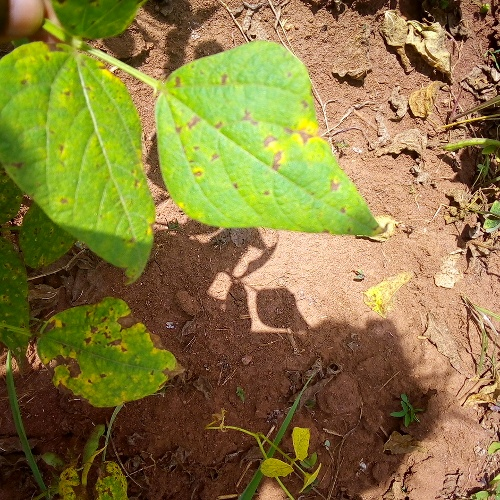

In [28]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg'))

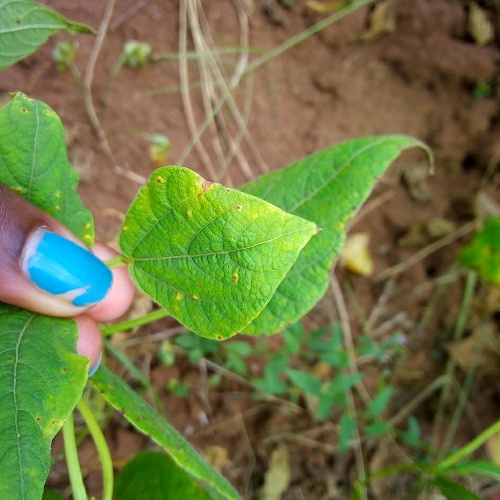

In [29]:
display(Image('beans/train/bean_rust/bean_rust_train.0.jpg'))

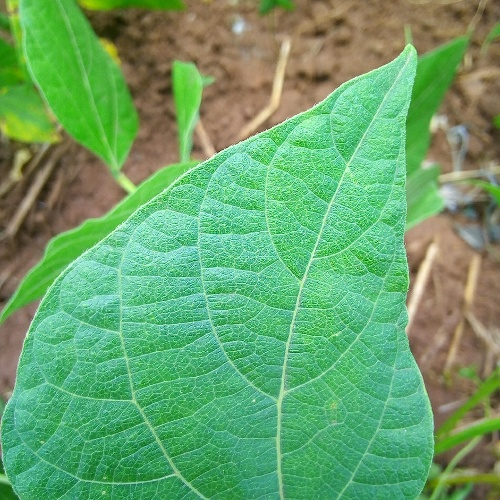

In [30]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

In [31]:
batch_size=128
img_height=224
img_width=224


In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)



val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
                                                               seed=111,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)



Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [33]:
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


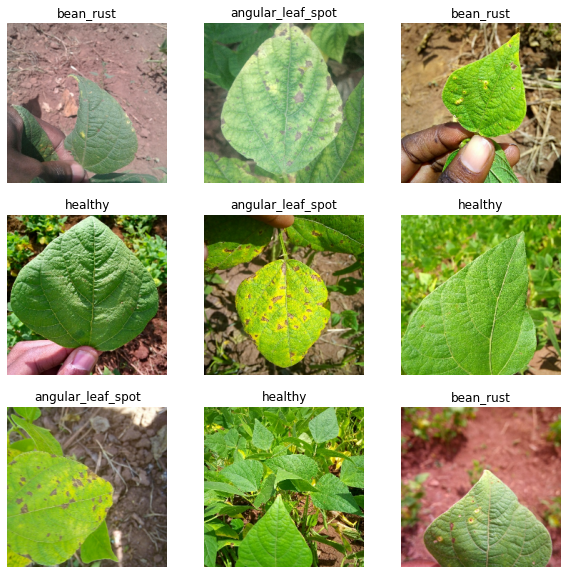

In [36]:
plt.figure(figsize=(10,10))
for image,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")


In [37]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [38]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [39]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))
feature_extractor_layer.trainable = False

In [40]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
tf.random.set_seed(111)

In [41]:
model = tf.keras.Sequential([
   normalization_layer,
   feature_extractor_layer,
   tf.keras.layers.Dropout(0.3),
   tf.keras.layers.Dense(3,activation='softmax')
])

In [44]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [45]:
history = model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 20s 497ms/step - loss: 1.1419 - accuracy: 0.4526 - val_loss: 0.7883 - val_accuracy: 0.6842
Epoch 2/20
9/9 [==============================] - 3s 290ms/step - loss: 0.8088 - accuracy: 0.6489 - val_loss: 0.6094 - val_accuracy: 0.7594
Epoch 3/20
9/9 [==============================] - 3s 289ms/step - loss: 0.6337 - accuracy: 0.7350 - val_loss: 0.5366 - val_accuracy: 0.7669
Epoch 4/20
9/9 [==============================] - 3s 291ms/step - loss: 0.5776 - accuracy: 0.7689 - val_loss: 0.4824 - val_accuracy: 0.7744
Epoch 5/20
9/9 [==============================] - 3s 290ms/step - loss: 0.5092 - accuracy: 0.8056 - val_loss: 0.4480 - val_accuracy: 0.7970
Epoch 6/20
9/9 [==============================] - 3s 290ms/step - loss: 0.4793 - accuracy: 0.8066 - val_loss: 0.4174 - val_accuracy: 0.8271
Epoch 7/20
9/9 [==============================] - 3s 290ms/step - loss: 0.4158 - accuracy: 0.8211 - val_loss: 0.3996 - val_accuracy: 0.8496
Epoch 8/20
9/9 [===

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

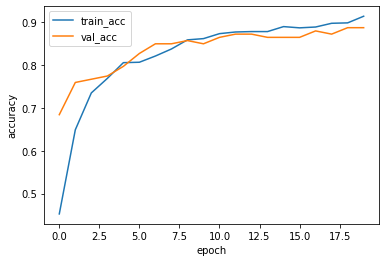

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'],loc='best')
plt.show()

In [50]:
result = model.evaluate(test_ds)

1/1 [==============================] - 1s 718ms/step - loss: 0.2790 - accuracy: 0.8906


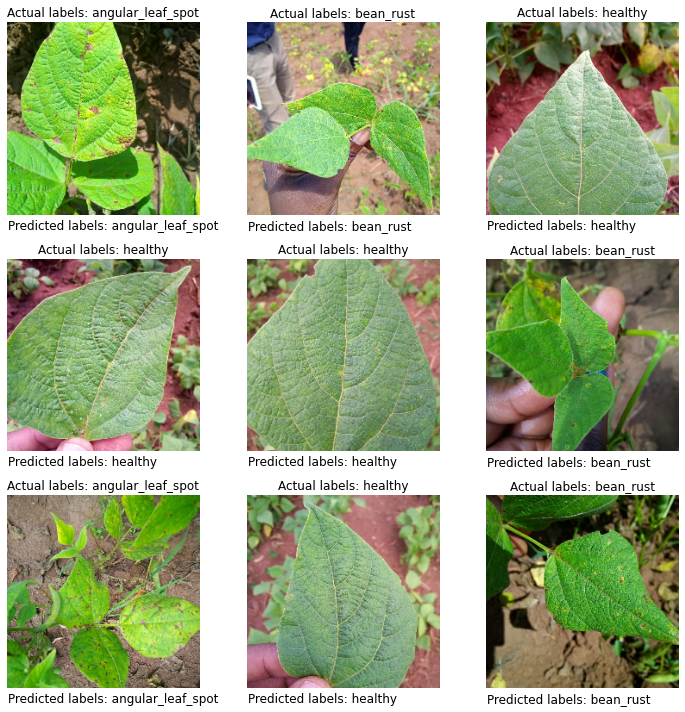

In [52]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img,axis=0)

    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title("Actual labels: {}".format(classes[labels[i]]))
    plt.text(1,240,"Predicted labels: {}".format(classes[np.argmax(pred)]),fontsize=12)
    plt.axis('off')


In [53]:
model.save('./models',save_format='tf')


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [54]:
!ls models

assets	keras_metadata.pb  saved_model.pb  variables


In [55]:
model_loaded = tf.keras.models.load_model('./models')


In [56]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [58]:
!ls -alrt models

total 1876
drwxr-xr-x 1 root root    4096 Dec 12 19:19 ..
drwxr-xr-x 2 root root    4096 Dec 12 19:19 variables
drwxr-xr-x 2 root root    4096 Dec 12 19:19 assets
-rw-r--r-- 1 root root 1895999 Dec 12 19:19 saved_model.pb
-rw-r--r-- 1 root root    6847 Dec 12 19:19 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Dec 12 19:19 .


In [61]:
def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224,224,3))
  np_image = np.expand_dims(np_image,axis=0)
  return np_image


In [62]:
pred_label = model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])


healthy


In [63]:
pred_label

array([[8.9304015e-04, 3.9689273e-02, 9.5941770e-01]], dtype=float32)

In [64]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/assets/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)


In [65]:
print(tf.__version__)

2.7.0


In [66]:
!ls models

assets	keras_metadata.pb  saved_model.pb  variables


In [67]:
!ls

beans  models  models.zip  sample_data	test.zip  train.zip  validation.zip
